# Example Gawain notebook
In this notebook I show how to set up, run, and plot a simple simulation using the gawain plasma physics module.


In [22]:
import numpy as np
from gawain.main import run_gawain
from gawain.io import Reader

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# Set up run
Here we define the simulation parameters and initial and boundary conditions.
For this simple example, I use the Sod shock tube problem. This is a 1D hydrodynamics problem, and so mhd routines are turned off.

First define the run_name and output directory, this will create a directory containing the output from the simulation.

In [24]:
run_name = "sod_shock_tube"
output_dir = "."

Here I choose whether to run an MHD or Hydro simulation, and whether to turn on thermal conductivity and resistivty. As the Sod shock tube is a hydrodynamic problem, MHD and resistivity are turned off. I also do not turn on thermal conductivity.

In [25]:
with_mhd = False
with_thermal_conductivity = False
with_resistivity = False

These cells define the cfl number, the total simulation time, and which time integrator and flux calculation methods are to be used. 

Currently the supported time integration methods are
- euler forward step
- 2nd order Runge-Kutta
- Leapfrog
- Predictor-Corrector

The currently supported flux calculation methods are
- Lax-Wendroff (two-step Richtmeyer form)
- Lax-Friedrichs
- HLLE with MUSCL reconstruction

For all but the simplest simulations it is strongly advised to use HLL, as Lax-Wendroff is susceptible to oscillations about sharp discontinuities and Lax-Friedrichs is very diffusive.

In [26]:
cfl = 0.5
t_max = 0.25

In [27]:
# "euler", "rk2", "leapfrog", "predictor-corrector"
integrator = "euler"
# "lax-wendroff", "lax-friedrichs", "hll"
fluxer = "hll"

## Define mesh

This cell defines the mesh shape (number of cells in each direction), dimensions (length of each dimension) and the number of output dumps to use.

In [28]:
nx, ny, nz = 200, 1, 1

mesh_shape = (nx, ny, nz)

n_outputs = 100

lx, ly, lz = 1.0, 0.001, 0.001

mesh_size = (lx, ly, lz)

x = np.linspace(0.0, lx,num=nx)
y = np.linspace(0.0, ly,num=ny)
z = np.linspace(0.0, lz,num=nz)
X,Y,Z =np.meshgrid(x,y,z, indexing='ij')

## Define initial condition

The mesh information is used to create an initial condition. If this were an mhd simulation, the magnetic field initial condition would also need to be included.

In [29]:
adiabatic_idx = 7.0/5.0

rho = np.piecewise(X, [X < 0.5, X >= 0.5], [1.0, 0.125])

pressure = np.piecewise(X, [X < 0.5, X >= 0.5], [1.0, 0.1])

mx = np.zeros(X.shape)
my = mx
mz = mx

e = pressure/(adiabatic_idx-1) + mx*mx/rho

initial_condition = np.array([rho, mx, my, mz, e])

source = 0.0*np.ones(initial_condition.shape)

## Define boundary conditions
The available boundary conditions are
- periodic
- fixed (to the value specified in the initial condition)
- reflective

In [30]:
boundary_conditions = ['fixed', 'periodic', 'periodic']

In [31]:
config = {
    "run_name": run_name,
    "cfl": cfl,
    "mesh_shape": mesh_shape,
    "mesh_size": mesh_size,
    "t_max": t_max,
    "n_dumps": n_outputs,
    "initial_condition": initial_condition,
    "boundary_type": boundary_conditions,
    "adi_idx": adiabatic_idx,
    "integrator": integrator,
    "fluxer": fluxer,
    "output_dir": output_dir,
    "with_mhd": with_mhd,
    "source":source,
}

# Run Simulation
Combine all the above simulation parameters into a parameter dictionary. This dictionary is then fed to the run_gawain function which begins the simulation. Ensure the all keys for this dictionary are defined, and ensure the names are spelt correctly.

In [32]:
run_gawain(config)

  9%|▊         | 0.022597750405054066/0.26 [00:00<00:01,  4.43s/it]


   ______                     _
  / ____/___ __      ______ _(_)___
 / / __/ __ `/ | /| / / __ `/ / __ |
/ /_/ / /_/ /| |/ |/ / /_/ / / / / /
\____/\__,_/ |__/|__/\__,_/_/_/ /_/
-----------------------------------
      R-MHD simulation code
-----------------------------------
Simulation parameters:

run name:  sod_shock_tube
clf condition = 0.5
nx, ny, nz = (200, 1, 1)
lx, ly, lz = (1.0, 0.001, 0.001)
t max = 0.25
fluxer:  hll
integrator:  euler
boundary types:  ['fixed', 'periodic', 'periodic']
-----------------------------------


 96%|█████████▌| 0.25000344217967974/0.26 [00:01<00:00,  4.87s/it] 


Simulation Complete, duration: 1.25 seconds


# Plot Results
One can create simple plots to visualise the results using the Reader object 

In [33]:
data = Reader('sod_shock_tube')

In [34]:
data.variables

['density', 'xmomentum', 'ymomentum', 'zmomentum', 'energy']

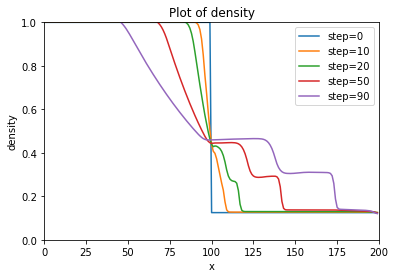

In [35]:
data.plot('density', timesteps=[0,10,20,50,90])

One can also create animations from the raw data using the method below

In [36]:
raw_data = data.get_data('density')

In [37]:
raw_data.shape

(100, 200, 1, 1)

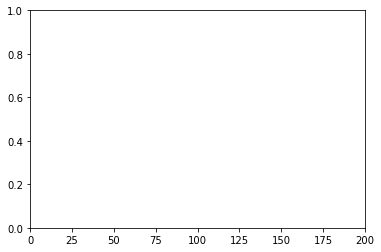

In [38]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 200))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw=2)

In [39]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [40]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 200, 200)
    y = raw_data[i].reshape(200,)
    line.set_data(x, y)
    return (line,)

In [41]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

In [42]:
HTML(anim.to_jshtml())